# Fragility Data Analysis - Compute State Evolution Matrices
Using this notebook to prototype the functions to compute the state evolution of each dataset

In [24]:
import pandas as pd
import numpy as np
import json
from IPython.display import display
import os

import scipy, scipy.io
try:
    import cPickle as pickle
except:
    import pickle

import gzip
import cStringIO
import bz2,json,contextlib

import matplotlib
from matplotlib import *
from matplotlib import pyplot as plt
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')
from natsort import natsorted, ns

%matplotlib inline

## sklearn imports
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.tree
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.pipeline
import sklearn.grid_search

import loadmat

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
## Take .mat EEG files and convert them to .json data

patients = [
            'pt1sz2', 'pt1sz3', 'pt1sz4', \
            'pt2sz1', 'pt2sz3', 
            'pt2sz4', \
            'pt3sz2', 'pt3sz4', 'pt6sz3', 'pt6sz4', 'pt6sz5', \
            'pt7sz19', 'pt7sz21', 'pt7sz22', \
            'pt8sz1', 'pt8sz2', 'pt8sz3', \
            'JH101sz1', 'JH101sz2', 'JH101sz3', 'JH101sz4', \
            'JH102sz1', 'JH102sz2', 'JH102sz3', 'JH102sz4', 'JH102sz5', 'JH102sz6', \
            'JH103sz1', 'JH103sz2', 'JH103sz3', \
            'JH104sz1', 'JH104sz2', 'JH104sz3', \
            'JH105sz1', 'JH105sz2', 'JH105sz3', 'JH105sz4', 'JH105sz5',\
            'JH106sz1', 'JH106sz2', 'JH106sz3', 'JH106sz4', 'JH106sz5', 'JH106sz6', \
            'JH107sz1', 'JH107sz2', 'JH107sz3', 'JH107sz4', 'JH107sz5', 'JH107sz6', 'JH107sz7', 'JH107sz8', 'JH107sz9', \
            'JH108sz1', 'JH108sz2', 'JH108sz3', 'JH108sz4', 'JH108sz5', 'JH108sz6', 'JH108sz7'
           ]
EXTERNAL = 0

# initialize directory with data
dataDir = '../fragility_dataanalysis/data/'
iiDataDir = '../fragility_dataanalysis/data/interictal_data/'
newDataDir = '../fragility_dataanalysis/data/json/' # new directory to save data

if EXTERNAL:
    dataDir = '/Volumes/NIL_PASS/data/'
    iiDataDir = '/Volumes/NIL_PASS/data/interictal_data/'
    newDataDir = '/Volumes/NIL_PASS/data/json/'
    
print 'EXTERNAL IS: ', EXTERNAL

EXTERNAL IS:  0


## Prototype of LTV Model Class


In [178]:
from scipy import signal
import numpy as np

class LinearTimeModel(object):
    """ A Linear Time Invariant Model used for EEG data analysis. Each LTI model has the following
    attributes:
    
    Attributes:
    - winSize: the window size used to construct a model from data
    - stepSize: the step size to slide window over data
    - filterType: the filter applied to data before constructing model (None, notch, adaptive)
    - l2: regularization parameter to enforce some degree of smoothness and sparsity
    - frequency: the frequency sampling in Hz
    - modelType: the type of model used 
    - clinicalModel: a link to a clinical model if applicable
    """
    
    def __init__(self, name, winSize=250, stepSize=125, filterType='adaptive', frequency=1000, l2=0, modelType='least-squares', clinicalModel=None):
        self.name = name
        self.winSize = winSize
        self.stepSize = stepSize
        self.filterType = filterType
        self.frequency = frequency
        self.l2 = l2
        self.modelType = modelType
        self.clinicalModel = clinicalModel
        
    def filter_data(self, data, params):
        if self.filterType == 'notch':
            print "Notch filtering..."
            self.filtered_data = buttfilt(data, freq_range=np.array([59.5, 60.5]), sample_rate=self.frequency, filt_type='bandstop', order=1)

        elif self.filterType == 'adaptive':
            print "Adaptive filtering..."
        else:
            print "No filter applied to data. Are you sure?"
            
        return data
        
#     def compute_model(self, data):
        

def removePowerLine(data, num_harmonics, B, P, W, fs=1000., f_ac=None):
    # get shape of data matrix
    num_chans, num_time = data.shape
    s = np.zeros((num_chans, num_time), dtype=float)
    M = num_harmonics
    nyq_fs = fs/2
    
    # if power line frequency is known, set cut off frequencies
    if f_ac and f_ac==50:
        fc1 = 48
        fc2 = 52
    elif f_ac and f_ac==60:
        fc1 = 58
        fc2 = 62
    else:
        fc1 = 40
        fc2 = 70
        
    exChan = 0 # a channel to estimate the frequencies at
    
    # remove mean from the data to center at 0
    data = data - np.mean(data, axis=0)
    
    # 3dB cutoff bandwidths
    alpha_o = (1 - np.arctan(np.pi * B[0]/fs)) / (1 + np.arctan(np.pi * B[0]/fs)) # initial alpha_0
    alpha_inf = (1 - np.tan(np.pi * B[1]/fs)) / (1 + np.tan(np.pi * B[1]/fs))     # asymptotic value
    alpha_st = np.exp(np.log(0.05) / (B[2] * fs + 1))                             # rate of change
    
    # frequency estimator's forgetting factors
    lambda_o = np.exp(np.log(0.05) / (P[0] * fs + 1))                             # initial lambda_0
    lambda_inf = np.exp(np.log(0.05) / (P[1] * fs + 1))
    lambda_st = np.exp(np.log(0.05) / (P[2] * fs + 1))
    
    # smoothing parameter
    gamma = (1 - np.tan(0.5 * np.pi * np.minimum(90, fs/2) / fs)) / (1 + np.tan(0.5 * np.pi * np.minimum(90, fs/2)/fs))
    
    # phase/amplitude estimator forgetting factor
    lambda_a = np.exp(np.log(0.05) / (W * fs + 1))
    if lambda_a.size == 1:
        lambda_a = np.ndarray.flatten(lambda_a * np.ones((1, M)))
    
    # initialize variables
    kappa_f = 0
    kappa_k = np.zeros((M+2,1))
    D = 10
    C = 5
    f_n1 = 0
    f_n2 = 0
    
    # initialize first oscillator
    u_kp = np.ones((M,1)) # u_k'
    u_k = np.ones((M,1))  # u_k
    
    # initialize RLS parameters
    r1 = 100 * np.reshape(np.ones((num_chans, M)), (num_chans, M))
    r4 = 100 * np.reshape(np.ones((num_chans, M)), (num_chans, M))
    a = np.reshape(np.zeros((num_chans, M)), (num_chans, M))
    b = np.reshape(np.zeros((num_chans, M)), (num_chans, M))
    
    # IIR Bandpass Filtering
    order = 4
    b_butter, a_butter = signal.butter(order, [fc1/nyq_fs, fc2/nyq_fs], btype='bandpass', analog=False, output='ba')
    data_f = signal.filtfilt(b_butter, a_butter, data[exChan, :]) # perform band pass filtering 
    data_f = np.append(np.array((0)), np.diff(data_f))
    
    ## Start Data Processing
    for t in range(0, num_time):
        # lattice filter
        f_n = data_f[t] + kappa_f*(1 + alpha_o)*f_n1 - alpha_o*f_n2
        
        # frequency estimation
        C = lambda_o*C + (1-lambda_o) * f_n1*(f_n+f_n2)
        D = lambda_o*D + (1-lambda_o) * 2 * f_n1**2.
        kappa_t = C/D
        if kappa_t < -1:
            kappa_t = -1
        elif kappa_t > 1:
            kappa_t = 1
        kappa_f = gamma*kappa_f + (1-gamma)*kappa_t
        
        # update lattice states
        f_n2 = f_n1
        f_n1 = f_n
        
        # Bandwidth and Forgetting Factor updates
        alpha_f = alpha_st*alpha_o + (1-alpha_st)*alpha_inf
        lambda_f = lambda_st*lambda_o + (1-lambda_st)*lambda_inf
        
        # Discrete Time Oscillators
        kappa_k[1] = 1
        kappa_k[0] = kappa_f
        e = data[:, t]
        
        # loop through each harmonic
        for k in range(0, num_harmonics):
            kappa_k[k+2] = 2*kappa_f*kappa_k[k+1] - kappa_k[k]
            
            # Oscillator
            temp = kappa_k[k+2] * (u_k[k] + u_kp[k])
            temp2 = u_k[k]
            u_k[k] = temp - u_kp[k]
            u_kp[k] = temp + temp2
            
            # Gain Control
            G = 1.5 - (u_k[k]**2 - (kappa_k[k+2]-1) / (kappa_k[k+2] + 1)*u_kp[k]**2)
            if G < 0:
                G = 1
            u_k[k] = G* u_k[k]
            u_kp[k] = G * u_kp[k]
            
            # Process multiple channels with Phase/Amplitude Adaptation
            sincmp = a[:, k]*u_kp[k] + b[:,k]*u_k[k]
            e = e - sincmp
            
            # Simplified RLS
            r1[:, k] = lambda_a[k]*r1[:,k] + u_kp[k]**2
            r4[:, k] = lambda_a[k]*r4[:,k] + u_k[k]**2
            a[:,k] = a[:,k] + u_kp[k]*e / r1[:,k]
            b[:,k] = b[:,k] + u_k[k]*e / r4[:,k]
            
            # end of loop through harmonics
        # end of loop through time
        s[:,t] = e
    return s

def buttfilt(data, freq_range, sample_rate=1000., filt_type='bandstop', order=1, num_harmonics=None):
    nyq_fs = sample_rate/2 # nyquist frequency
    if not num_harmonics:
        num_harmonics = int(np.floor(sample_rate / 120)) - 1
    
    if isinstance(freq_range, list):
        freq_range = np.array(freq_range)
    
    # go through each harmonic and filter it out
    for i in range(0, num_harmonics):
        b, a = signal.butter(order, list(freq_range/nyq_fs), btype=filt_type)
        freq_range = freq_range+60
        
        # apply zero-phase distortion filtering on data
        data = signal.filtfilt(b, a, data)
        
    return data

## Testing Adaptive Filtering and Notch Filtering
Here, we want to test the functions above for notch and adaptive filtering for time series data.

In [179]:
for i in range(0, 3):
    print i

0
1
2


(10240,)


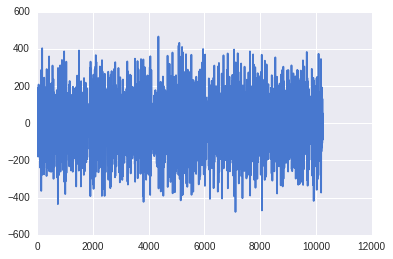

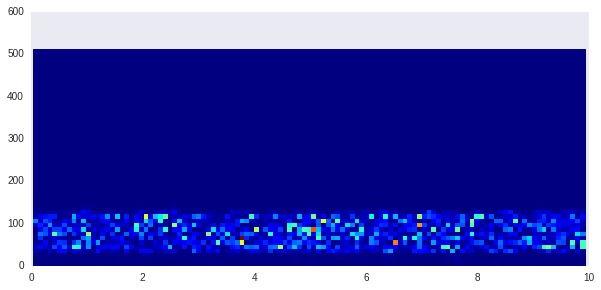

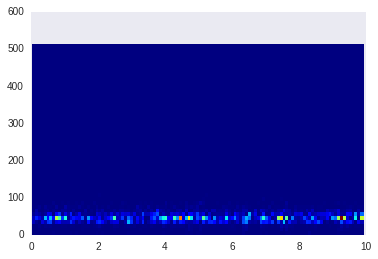

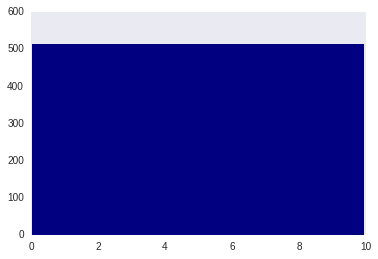

In [183]:
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1024.):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

x = band_limited_noise(30, 120, samples=10240)
x = np.int16(x * (2**15 - 1))

ft = scipy.fftpack.fft(x)

# Raw data
plt.figure()
plt.plot(x)

f, t, spect = scipy.signal.spectrogram(x, fs=1024., nperseg=100)

# Spectrogram of data
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.pcolormesh(t, f, spect, cmap='jet')
plt.colorbar

# plt.subplot(212)
# plt.plot(np.abs(ft))

# Spectrogram of data after notch
x_new = buttfilt(x, freq_range=np.array([30, 50]), sample_rate=1024., filt_type='bandpass', num_harmonics=1)

f, t, spect = scipy.signal.spectrogram(x_new, fs=1024., nperseg=100)
plt.figure()
plt.pcolormesh(t, f, spect,cmap='jet')


# adaptive filtered...
x_new = removePowerLine(np.reshape(x, (1, len(x))), 2, [50, 0.01, 4], [0.1, 2, 4], 2)

f, t, spect = scipy.signal.spectrogram(np.ndarray.flatten(x_new), fs=1024., nperseg=100)
plt.figure()
plt.pcolormesh(t, f, spect,cmap='jet')

## Prototype of Clinical Data Model
This will be the class that holds clinical data for a certain patient dataset

In [ ]:
class ClinicalModel(object):
    """
    
    """
    def __init__(self, name, ez_labels=None, earlyspread_labels=None, latespread_labels=None, resection_labels=None,\
                 clinical_onset_ms=None, clinial_offset_ms=None,\
                 elec_onset_ms=None, elec_offset_ms=None,\
                 elec_xyz=None, center=None, elec_labels=None, included_indices=None):
        self.name = name
        self.ez_labels = ez_labels
        self.earlyspread_labels = earlyspread_labels
        self.latespread_labels = latespread_labels
        self.resection_labels = resection_labels
        self.clinical_onset_ms = clinical_onset_ms
        self.clinial_offset_ms = clinial_offset_ms
        self.elec_onset_ms = elec_onset_ms
        self.elec_offset_ms = elec_offset_ms
        self.elec_xyz = elec_xyz
        self.center = center
        self.elec_labels = elec_labels
        self.included_indices = included_indices
    
    

## Prototype of Perturbation Model 
This is the class that stores the perturbation computed matrices, minimum norm deltas and fragility metric for the linear time varying model.

In [32]:
class PerturbationModel(object):
    """
    
    """
    def __init__(self, name, radius=1.0, perturbationType='C'):
        self.name = name
        self.radius = radius
        self.perturbation_type = perturbation_type
        
    

In [5]:
# get mat files in a patient's directory
patient = patients[0]

for patient in patients:
    print "Starting patient ", patient
    
    patientDir = newDataDir + patient + '/'
    jsonFiles = []
    for file in os.listdir(patientDir):
        if file.endswith('.json'):
            jsonFiles.append(file)

    if len(jsonFiles) > 1:
        print "There is too many .mat files in this directory!"
        print "Check patient ", patient

#     matFile = patientDir + matFiles[0]
#     data = loadmat(matFile)

#     fileName = newDataDir + patient + 'raw.json.bz2'
#     try:
#         convertMatToJSON(data, fileName)
#     except:
#         print "Problem with ", patient


Starting patient  pt1sz2


OSError: [Errno 2] No such file or directory: '../fragility_dataanalysis/data/json/pt1sz2/'